## Overview

This project aims to build a model that can predict a property's price based on it's features to help with house valuations .

## Business Problem

Which features are most relevant to a house's price and how much do they affect it?

In [50]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

Loading the dataset and defining the continuous and categorical variables that we will use.

In [51]:
kc = pd.read_csv("kc_house_data.csv")

continuous = ['price','sqft_living', 'sqft_lot', 'sqft_above']
categorical = ['bedrooms', 'bathrooms', 'floors', 'waterfront','condition', 'grade',]

## Data Preparation

### Data transformation for categorical variables
One hot encoding is first done on the categorical data. A dictionary is also produced as a reference for what each value was encoded as.

In [54]:
kc_cat = kc[categorical]

from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

kc_cat_encoded = pd.DataFrame([])

mapping ={}

for column in kc_cat.columns:
    kc_cat_encoded[column] = lb_make.fit_transform(kc_cat[column].astype(str))
    mapping[column] = dict(zip(lb_make.classes_, lb_make.transform(lb_make.classes_)))

for column, map_dict in mapping.items():
    print(f"Mapping for {column}:")
    print(map_dict)

Mapping for bedrooms:
{'1': 0, '10': 1, '11': 2, '2': 3, '3': 4, '33': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11}
Mapping for bathrooms:
{'0.5': 0, '0.75': 1, '1.0': 2, '1.25': 3, '1.5': 4, '1.75': 5, '2.0': 6, '2.25': 7, '2.5': 8, '2.75': 9, '3.0': 10, '3.25': 11, '3.5': 12, '3.75': 13, '4.0': 14, '4.25': 15, '4.5': 16, '4.75': 17, '5.0': 18, '5.25': 19, '5.5': 20, '5.75': 21, '6.0': 22, '6.25': 23, '6.5': 24, '6.75': 25, '7.5': 26, '7.75': 27, '8.0': 28}
Mapping for floors:
{'1.0': 0, '1.5': 1, '2.0': 2, '2.5': 3, '3.0': 4, '3.5': 5}
Mapping for waterfront:
{'0.0': 0, '1.0': 1, 'nan': 2}
Mapping for condition:
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}
Mapping for grade:
{'10': 0, '11': 1, '12': 2, '13': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}


In [ ]:
kc_cat_encoded = kc_cat_encoded.astype('category')

dummies = pd.get_dummies(kc_cat_encoded, drop_first=True)
kc_cat_ohe = pd.concat([kc_cat_encoded.drop(categorical, axis=1), dummies], axis=1)
kc_cat_ohe = kc_cat_ohe.astype(int)

The encoded categorical data is then concatenated back into the main dataset and the original columns are dropped.

In [8]:
kc = kc.drop(columns=['bedrooms','bathrooms', 'floors', 'waterfront','condition', 'grade'])
kc = pd.concat([kc, kc_cat_ohe],axis=1)
kc.head()

,id,date,price,sqft_living,sqft_lot,view,sqft_above,sqft_basement,yr_built,yr_renovated,...,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10
0,7129300520,10/13/2014,221900.0,1180,5650,0.0,1180,0.0,1955,0.0,...,0,0,0,0,0,0,0,1,0,0
1,6414100192,12/9/2014,538000.0,2570,7242,0.0,2170,400.0,1951,1991.0,...,0,0,0,0,0,0,0,1,0,0
2,5631500400,2/25/2015,180000.0,770,10000,0.0,770,0.0,1933,NaN,...,0,0,0,0,0,0,1,0,0,0
3,2487200875,12/9/2014,604000.0,1960,5000,0.0,1050,910.0,1965,0.0,...,0,0,0,0,0,0,0,1,0,0
4,1954400510,2/18/2015,510000.0,1680,8080,0.0,1680,0.0,1987,0.0,...,0,0,0,0,0,0,0,0,1,0


The remaining unwanted columns are dropped and we now have the main dataset that we will use.

In [9]:
kc = kc.drop(columns=['id', 'date', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15'
                     ,'sqft_lot15', 'view'])

In [10]:
kc.head()

,price,sqft_living,sqft_lot,sqft_above,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,...,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10
0,221900.0,1180,5650,1180,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,538000.0,2570,7242,2170,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,180000.0,770,10000,770,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,604000.0,1960,5000,1050,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,510000.0,1680,8080,1680,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


### Train-Test Split

Implement a train-test split so that we can evaluate the model's performance on unseen data.

In [11]:
from sklearn.model_selection import train_test_split

kc_train, kc_test = train_test_split(kc, random_state=42)

In [12]:
kc_train_cont = kc_train[continuous]
kc_train_cat = kc_train.drop(columns=['price','sqft_living', 'sqft_lot', 'sqft_above'])

### Data Transformation for Continuous variables
The continuous features are separated into it's own dataset. Histograms are plotted for each variable to check if they follow a normal distribution.

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'sqft_living'}>],
       [<Axes: title={'center': 'sqft_lot'}>,
        <Axes: title={'center': 'sqft_above'}>]], dtype=object)

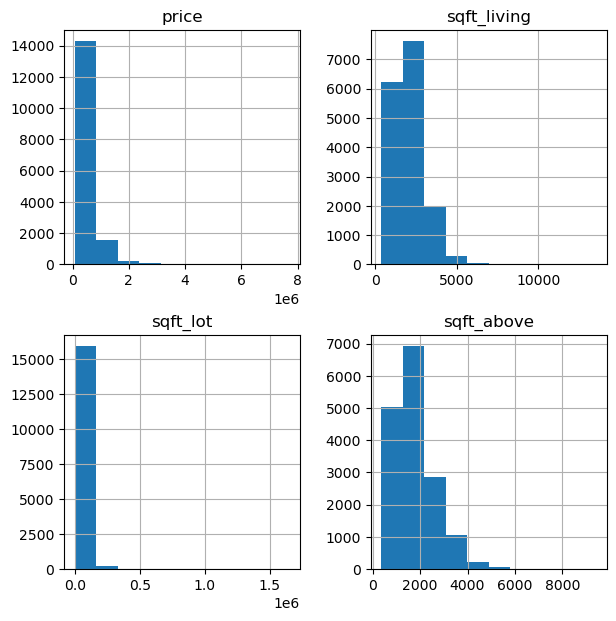

In [13]:
kc_train_cont.hist(figsize = [7,7])

### Log transformation and Min-Max scaling
A log transformation is done to address the skewness and the data is scaled through min-max scaling.

array([[<Axes: title={'center': 'price_log'}>,
        <Axes: title={'center': 'sqft_living_log'}>],
       [<Axes: title={'center': 'sqft_lot_log'}>,
        <Axes: title={'center': 'sqft_above_log'}>]], dtype=object)

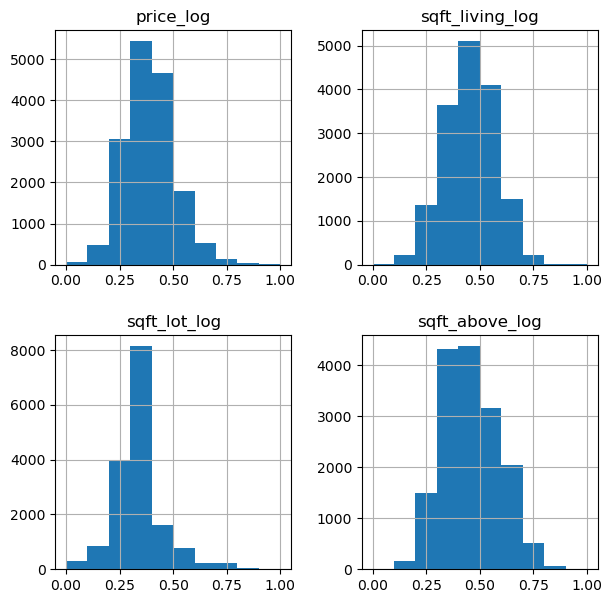

In [17]:
kc_train_log = pd.DataFrame([])

for column in kc_train_cont.columns:
    transformed_column = np.log(kc_train_cont[column])
    kc_train_log[column + '_log'] = transformed_column

    
def min_max(feature):
    return (feature - feature.min()) / (feature.max()-feature.min())

kc_train_norm = kc_train_log.apply(min_max)
kc_train_norm.hist(figsize = [7,7])    

### Final training dataset
Both the categorical and continuous variables are combined to create our training dataset.

In [18]:
kc_train_norm = kc_train_norm.reset_index().drop(columns=['index'])
kc_train_cat = kc_train_cat.reset_index().drop(columns=['index'])

In [19]:
train_preprocessed = pd.concat([kc_train_norm, kc_train_cat], axis=1)
train_preprocessed

,price_log,sqft_living_log,sqft_lot_log,sqft_above_log,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,...,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10
0,0.416849,0.451547,0.267606,0.502321,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.256231,0.471499,0.314453,0.390689,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.491408,0.707259,0.850215,0.732533,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.423337,0.375546,0.249249,0.417774,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.350467,0.503912,0.511350,0.478407,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16192,0.376735,0.498973,0.299107,0.555080,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
16193,0.433866,0.559210,0.248350,0.622090,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
16194,0.293190,0.394322,0.353597,0.438662,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
16195,0.249234,0.007408,0.416949,0.008241,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Data Analysis

### Stepwise Selection
To create a stronger model, we now run the features through stepwise selection to create a list of variables that can be used in the final model.

In [20]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):

    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [21]:
X = train_preprocessed.drop('price_log', axis=1)
y_train = train_preprocessed['price_log']

result = stepwise_selection(X, y_train, verbose = True)
print('resulting features')
print(result)

Add  sqft_above_log                 with p-value 0.0
Add  sqft_living_log                with p-value 0.0
Drop sqft_above_log                 with p-value 0.321908
Add  bedrooms_3                     with p-value 8.45272e-116
Add  waterfront_1                   with p-value 1.46583e-91
Add  grade_8                        with p-value 2.24592e-84
Add  grade_7                        with p-value 6.62021e-117
Add  grade_9                        with p-value 8.98348e-151
Add  grade_6                        with p-value 1.92038e-128
Add  bathrooms_8                    with p-value 4.48131e-98
Add  floors_1                       with p-value 2.54146e-75
Add  grade_10                       with p-value 1.94881e-75
Add  condition_4                    with p-value 4.77612e-69
Add  sqft_lot_log                   with p-value 1.53901e-50
Add  condition_3                    with p-value 1.01502e-35
Add  grade_5                        with p-value 2.2921e-36
Add  sqft_above_log                 with

### Model creation

In [22]:
X_fin = X[result]
X_with_intercept = sm.add_constant(X_fin)
kc_model = sm.OLS(y_train, X_with_intercept).fit()
kc_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     856.3
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:37:26   Log-Likelihood:                 19775.
No. Observations:               16197   AIC:                        -3.949e+04
Df Residuals:                   16166   BIC:                        -3.925e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3232      0.009     37.838      0.000       0.306       0.340
sqft_living_log     0.4853      0.011     42.509      0.000       0.463       0.508
bedrooms_3          0.0293      0.002     15.047      0.000       0.025       0.033
waterfront_1        0.1379      0.007     19.994      0.000       0.124       0.151
grade_8            -0.1475      0.003    -46.139      0.000      -0.154      -0.141
grade_7            -0.1903      0.004    -47.840      0.000      -0.198      -0.182
grade_9            -0.1000      0.003    -33.631      0.000      -0.106      -0.094
grade_6            -0.2150      0.006    -33.214      0.000      -0.228      -0.202
bathrooms_8        -0.0175      0.002    -11.155      0.000      -0.021      -0.014
floors_1            0.0380      0.002     18.410      0.000       0.034       0.042
grade_10           -0.0423      0.003    -14.015      0.000      -0.048      -0.036
condition_4         0.0605      0.006      9.609      0.000       0.048       0.073
sqft_lot_log       -0.0736      0.006    -12.549      0.000      -0.085      -0.062
condition_3         0.0353      0.006      5.829      0.000       0.023       0.047
grade_5            -0.2222      0.018    -12.413      0.000      -0.257      -0.187
sqft_above_log     -0.1065      0.009    -11.233      0.000      -0.125      -0.088
grade_2             0.0920      0.009      9.966      0.000       0.074       0.110
grade_1             0.0437      0.005      8.904      0.000       0.034       0.053
grade_3             0.1953      0.026      7.659      0.000       0.145       0.245
bathrooms_2         0.0080      0.002      3.815      0.000       0.004       0.012
floors_3            0.0340      0.007      5.034      0.000       0.021       0.047
floors_4            0.0175      0.004      4.815      0.000       0.010       0.025
bathrooms_13        0.0282      0.007      4.001      0.000       0.014       0.042
bathrooms_15        0.0343      0.009      3.733      0.000       0.016       0.052
bathrooms_7        -0.0068      0.002     -3.262      0.001      -0.011      -0.003
condition_2         0.0195      0.006      3.233      0.001       0.008       0.031
bathrooms_4        -0.0075      0.002     -3.082      0.002      -0.012      -0.003
bathrooms_22        0.1201      0.042      2.843      0.004       0.037       0.203
bathrooms_11        0.0108      0.004      2.947      0.003       0.004       0.018
bathrooms_17        0.0456      0.017      2.738      0.006       0.013       0.078
bathrooms_14        0.0184      0.007      2.614      0.009       0.005       0.032
==============================================================================
Omnibus:                       10.636   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.005   Jarque-Bera (JB):            

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

## Performance testing

### Cross-validation
Cross-validating the model with a division of 10 subsets to check how well it generalises on the training data.

In [35]:
X_fin = X[result]

linreg = LinearRegression()
cross_val_results =cross_validate(linreg, X_fin, y_train, cv=10, scoring = ['neg_mean_squared_error'], return_train_score=True)
cross_val_results

{'fit_time': array([0.00900221, 0.00800133, 0.00800204, 0.00800252, 0.00900221,
        0.00800133, 0.00800204, 0.0080018 , 0.0070014 , 0.00800109]),
 'score_time': array([0.00199962, 0.00099993, 0.00199986, 0.00200009, 0.00099993,
        0.00200081, 0.00199962, 0.00199962, 0.00100017, 0.0010004 ]),
 'test_neg_mean_squared_error': array([-0.00535675, -0.00527607, -0.00475298, -0.00543086, -0.00494657,
        -0.00503822, -0.00538179, -0.00480169, -0.00500323, -0.00519012]),
 'train_neg_mean_squared_error': array([-0.0050667 , -0.00507573, -0.00513287, -0.00505795, -0.00511159,
        -0.00510157, -0.00506344, -0.00512747, -0.00510504, -0.00508443])}

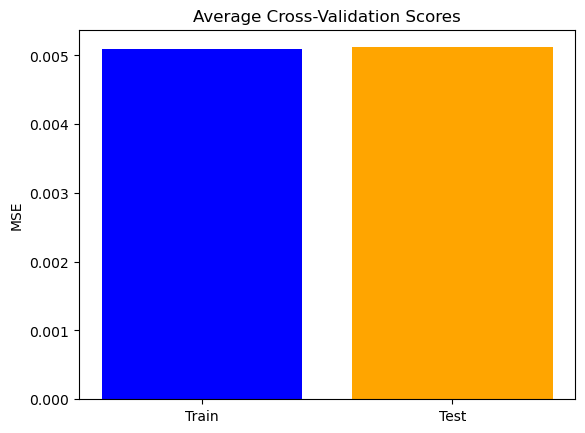

0.005092679908739233 0.005117828110749373


In [36]:
train_avg = -cross_val_results["train_neg_mean_squared_error"].mean()
test_avg = -cross_val_results["test_neg_mean_squared_error"].mean()

labels = ['Train', 'Test']
colors = ['blue', 'orange']

plt.bar(labels, [train_avg, test_avg], color=colors)
plt.ylabel("MSE")
plt.title("Average Cross-Validation Scores")
plt.show()
print(train_avg, test_avg)

As seen above, the model performs very well across itself with the training and testing scores being very similar to each other.

### Train-Test 
We now run the whole model again using the training and testing data that we initially split to test it's performance on unseen data.

In [37]:
kc_test_cont = kc_test[continuous]

In [43]:
kc_test_log = pd.DataFrame([])

for column in kc_test_cont.columns:
    transformed_column = np.log(kc_test_cont[column])
    kc_test_log[column + '_log'] = transformed_column

kc_test_norm = kc_test_log.apply(min_max)

kc_test_norm = kc_test_norm.reset_index().drop(columns=['index'])
kc_test_norm.head()

,price_log,sqft_living_log,sqft_lot_log,sqft_above_log
0,0.105268,0.227967,0.349983,0.123903
1,0.362212,0.407641,0.304574,0.241048
2,0.401429,0.460830,0.560280,0.341215
3,0.327067,0.319753,0.186896,0.139780
4,0.447418,0.405564,0.246423,0.290126


In [44]:
kc_test_cat = kc_test.drop(columns=['price','sqft_living', 'sqft_lot', 'sqft_above'])
kc_test_cat = kc_test_cat.reset_index()

In [45]:
test_preprocessed = pd.concat([kc_test_norm, kc_test_cat], axis=1)
test_preprocessed

,price_log,sqft_living_log,sqft_lot_log,sqft_above_log,index,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,...,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10
0,0.105268,0.227967,0.349983,0.123903,3686,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0.362212,0.407641,0.304574,0.241048,10247,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0.401429,0.460830,0.560280,0.341215,4037,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.327067,0.319753,0.186896,0.139780,3437,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.447418,0.405564,0.246423,0.290126,19291,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,0.352232,0.327875,0.318481,0.217515,18276,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5396,0.450736,0.439132,0.281248,0.286855,15003,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5397,0.624323,0.648284,0.268738,0.569534,13478,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5398,0.505520,0.829504,0.413997,0.720224,18399,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [46]:
X_test = test_preprocessed.drop('price_log', axis=1)
y_test = test_preprocessed['price_log']

X_test_with_intercept = sm.add_constant(X_test[result])

test_predictions = kc_model.predict(X_test_with_intercept)

test_mse = mean_squared_error(y_test, test_predictions)

print("Mean Squared Error (MSE) on test set:", test_mse)

Mean Squared Error (MSE) on test set: 0.005767936284402055


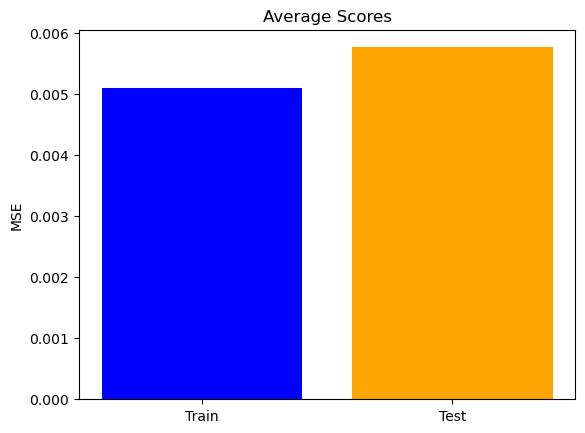

0.005093915031022525 0.005767936284402055


In [59]:
X_train = sm.add_constant(train_preprocessed[result])
y_train_pred = kc_model.predict(X_train)

X_test = sm.add_constant(test_preprocessed[result])
y_test_pred = kc_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

plt.bar(labels, [mse_train, mse_test], color=colors)
plt.ylabel("MSE")
plt.title("Average Scores")
plt.show()

print(mse_train, mse_test)

As seen through the train-test split, the model is expected to generalise well and should serve as a good predictor for house prices.

## Data Visualisation

### Coefficient plot

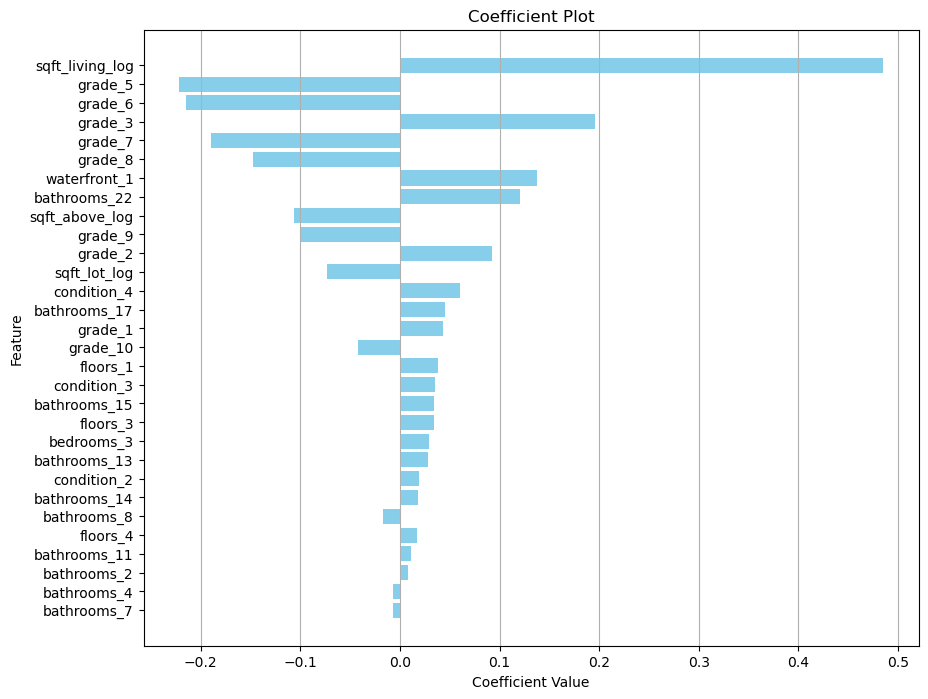

In [55]:
coefficients = kc_model.params[1:]
feature_names = coefficients.index

sorted_indices = np.argsort(np.abs(coefficients))
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_feature_names)), sorted_coefficients, color='skyblue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficient Plot')
plt.grid(axis='x')
plt.show()

## Summary

The most influential factors:
* Square footage of the living area
    * Larger living area positively affects price
* Grade
    * Having a building grade of 8 or lower negatively affects price
    * Having a building grade of 12 or higher positively affects price
* Waterfront 
    * Waterfront view positively affects price
* Condition
    * Conditions between 3-5 positively affect price